In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re
from cana.boolean_node import BooleanNode

# Some helpful fuinctions for converting between individual
# states and ints representing the joint states


def to_binary(n, digits):
    binary_digits = []
    for _ in range(digits):
        binary_digits.append(int(n % 2))
        n = int(n / 2)
    return np.array(binary_digits[::-1])


def to_decimal(b):
    expos = np.arange(len(b), 0, -1) - 1
    enc = 2**expos
    return np.array(b).T.dot(enc)


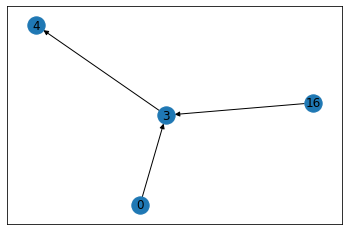

In [6]:
# ok so the real shit is we have to do this with markov blankets
mb_file = "../data/coarse_grained/markov_blankets/drosophila_melanogaster_mb_boolean.csv"
adj_mat = "../data/boolean_networks/adjacency_matrix/drosophila_melanogaster.csv"

# we'll focus on just the first markov blanket for now
mb = pd.read_csv(mb_file)
first_mb = mb.iloc[3]['markov_blanket'].replace('[', '').replace(']', '')
fmb = [int(n) for n in first_mb.split(', ')]

# ok we'll also need the adjacency matrix. it will help at least
adj_arr = np.loadtxt(adj_mat, dtype=int, delimiter=',')
fam = nx.from_numpy_array(adj_arr, create_using=nx.DiGraph)
fam_mb_0 = nx.subgraph(fam, fmb)

# draw the markov blanket
options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
pos = nx.spring_layout(fam_mb_0, seed=1234)
nx.draw_networkx(fam_mb_0, pos, options)
plt.show()


Ok, this is going to be an absolute nightmare. How the fuck. So my function
Above is not going to cut it here. There are way too many nodes. I think that
the right approach here is 'maxent whenever possible.' So what we need to do
is get all of the logic for all of the nodes in the markov blanket and then
for inputs whose states we know we will do the transitions and for nodes whose
input states we only partially know we will pick uniformly from the possible
transitions. I guess maybe we have all the nodes we need. we can find out by
listing all of the inputs from the logic file and then ensuring they match with
the network structure above.


In [7]:
# parse the logic file. We're going to store it as a list of output vectors
logic_file = "../data/boolean_networks/logic/apoptosis_network.txt"


def parse_logic_file(file_path):
    """
    This function will return the logic of each node in the cnet formatted file
    provided.

    Returns
    -------
    logic: list of dict
        dictionaryu has two keys: 'inputs': a list of inputs and 'outputs': a
            list of transitions in ascending order
    """
    with open(file_path, 'r') as fin:
        # this list will contain all the info for our network
        logic = []
        # we will define this dictionary here so we can use it in the logic
        new_entry = {}
        output_list = []
        for line in fin.readlines():
            # start of lines detailing new node
            if line[0] == '#' and len(new_entry) != 0:
                # add everything to the logic list
                new_entry['lut'] = np.array(output_list[::-1])
                logic.append(new_entry)
                # reset everything
                output_list = []
                new_entry = {}
            # these lines detail the inputs to a node
            elif line[:2] == '.n':
                split_inputs = line.split(' ')
                # cnet format counts from 1 not zero
                new_entry['inputs'] = [int(inp) - 1 for inp in split_inputs[3:]]
            # these detail the transitions in the opposite order that i like
            elif line[0] == '0' or line[0] == '1':
                look_up_table = [int(d) for d in ''.join(line.strip().split(' '))]
                output_list.append(look_up_table)

        # once all lines are parsed we will have to add things one last time
        new_entry['lut'] = np.array(output_list[::-1])
        logic.append(new_entry)
    
    return logic

# ok lets see
my_logic = parse_logic_file(logic_file)
print(my_logic[35]['inputs'])
print(my_logic[35]['lut'])


[0, 1, 2, 29]
[[0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [0 1 0 0 1]
 [0 1 0 1 0]
 [0 1 1 0 0]
 [0 1 1 1 0]
 [1 0 0 0 1]
 [1 0 0 1 0]
 [1 0 1 0 0]
 [1 0 1 1 0]
 [1 1 0 0 1]
 [1 1 0 1 0]
 [1 1 1 0 0]
 [1 1 1 1 0]]


Ok, so this is probably right. maybe should write a test but who knows.
certainly not me. now comes the hard part. we need to deal with the logic of
this fucker.

Heres what we know, what we are looking for is a matrix, $\mathbf{T}$ of 
size $2^N x 2^N$ where $N$ is the number of nodes in the markov blanket. At the
transition we will need to update and nodes whose inputs we know and randomize
any that we don't.

In [20]:
# ok its time to figure this shit out
def build_tpm(node_logic, markov_blanket):
    """
    Thakes the list from the parsed logic file and the graph (or maybe just
    the list of nodes idk) and returns the transition probability matrix for all
    possible states.
    This is fucking NON trivial
    """
    # set up the matrix
    N = len(markov_blanket.nodes)
    tpm = np.zeros((2**N, 2**N))

    # sort the markov blanket list so that we know that the first index is the
    # lowest number. Not sure that it matters but for building this thing it
    # will help my brain
    mb_list = sorted(markov_blanket.nodes)

    # I think I also need a dictionary that will let me do reverse lookups
    mb_rev = {nid: i for i, nid in enumerate(markov_blanket.nodes)}

    # lets get a list of nodes that have inputs in the markov blanket we will
    # probably have to get at like the logic here because we dont have all of
    # the inputs in all of the 
    logic_nodes = []
    transition_probs = [[]*N]
    in_mb_inputs = {nid: [] for nid in mb_list}
    prob_tables = {}
    for mbi, nid in enumerate(mb_list):
        # 'protected' networkx attr returned by G.predecessors[node_id]
        node_preds = markov_blanket._pred[nid]
        
        # if the node has any inputs in the markov blanket we have to do tons
        # of shitty bullshit
        if len(node_preds) > 0:
            # add to list of nodes with interesting logic
            logic_nodes.append(nid)
            
            # so we need to pull out the look up tables for each node and get
            # probabilities assuming all unobserved variables obey MaxEnt

            # this gets us a dictionary keyed by the node id with lists of
            # inputs in the markov blanket. we'll need this info later
            keep_cols = []
            for ii, inp in enumerate(node_logic[nid]['inputs']):
                if inp in node_preds:
                   keep_cols.append(ii)
                   in_mb_inputs[nid].append(inp)

            
            # we also need to keep the very last column
            keep_cols.append(-1)

            'this is an absolute fucking nightmare'

            # now we have to collapse the table by counting the number of
            # transitions into either state stored in a matrix with rows
            # for every unique input combination and one column for each output
            node_probs = np.zeros((2**(len(keep_cols) - 1), 2))
            thin_lut = node_logic[nid]['lut'][:, keep_cols]
            for row in thin_lut:
                in_idx = to_decimal(row[:-1])
                out_idx = row[-1]
                node_probs[in_idx, out_idx] += 1

            # turn the rowss into probability distributions
            row_sums = np.sum(node_probs, axis=1)
            node_probs = (node_probs.T / row_sums).T # why this behavior numpy?

            # put the transition array into a dictionary for lookup later
            prob_tables[nid] = node_probs

        # if node has no inputs in the markov blanket we just get to skip it!
        else:
            continue
            

    # we will think of the indices of the matrix as base 10 encodings of binary
    # vectors representing all of the states of all of the nodes. We can now
    # iterate over all positions in the matrix and determine the transitions
    for r in range(tpm.shape[0]):
        state = to_binary(r, N)
        # we can build an array that will have the probabilities of 
        # transitioning to ON or OFF for each node in the 
        transitions = np.zeros((N, 2))
        for nodei, value in enumerate(state):
            # we'll refer to the node id a bunch of times so lets assign it
            nid = mb_list[nodei]
            # if we dont have this nodes input nodes the node transitions
            # completely randomly
            if len(in_mb_inputs[nid]) == 0:
                transitions[nodei, :] = 0.5
            else:
                # we need to look up the probabilities from the tables we
                # we build up earlier
                input_idx = [mb_list.index(inpid) for inpid in in_mb_inputs[nid]]
                table_entry = to_decimal(state[input_idx])
                transitions[nodei, :] = prob_tables[nid][table_entry]
        
        # ok now we can iterate over the columns 
        for c in range(tpm.shape[1]):
            next_state = to_binary(c, N)
            probs = [transitions[i, st] for i, st in enumerate(next_state)]
            tpm[r, c] = np.product(probs)

    return tpm

my_tpm = build_tpm(my_logic, fam_mb_0)
print(np.sum(my_tpm, axis = 1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


I'm going to use this notebook to debug my tests. I can use the functions above and just plot out the TPMs

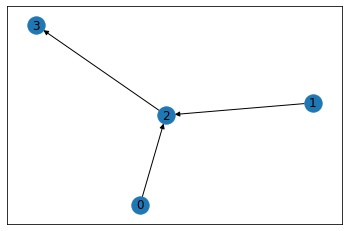

In [21]:
# Load the test "markov blanket"
test_am = np.loadtxt('../bio_synergy/tests/tester_adjacency_matrix.txt', dtype=int, delimiter=',')
test_graph = nx.from_numpy_array(test_am, create_using=nx.DiGraph)

# show the graph
pos = nx.spring_layout(test_graph, seed=1234)
nx.draw_networkx(test_graph, pos, options)
plt.show()

This is right, we also imagine two nodes outside of the markov blanket that are in the logic file, one affects node `1` and the other affects node `3`

In [22]:
# load the logic file
logic_dict = parse_logic_file('../bio_synergy/tests/tester_logic_file.txt')

# build the TPM
tpm = build_tpm(logic_dict, test_graph)
print(tpm)

[[0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.
  0.125 0.125 0.    0.   ]
 [0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.
  0.125 0.125 0.    0.   ]
 [0.    0.25  0.    0.    0.    0.25  0.    0.    0.    0.25  0.    0.
  0.    0.25  0.    0.   ]
 [0.    0.25  0.    0.    0.    0.25  0.    0.    0.    0.25  0.    0.
  0.    0.25  0.    0.   ]
 [0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125
  0.    0.    0.125 0.125]
 [0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125
  0.    0.    0.125 0.125]
 [0.    0.    0.    0.25  0.    0.    0.    0.25  0.    0.    0.    0.25
  0.    0.    0.    0.25 ]
 [0.    0.    0.    0.25  0.    0.    0.    0.25  0.    0.    0.    0.25
  0.    0.    0.    0.25 ]
 [0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125
  0.    0.    0.125 0.125]
 [0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125
  0.    0.    0.125 0.125]
 [0.

In [ ]:
def get_maxent_probs(node_logic: list, markov_blanket: nx.DiGraph) -> dict:
    """
    This function returns a dictionary of arrays that describe the probability 
    of each node transitioning to each state given the states of the nodes' 
    inputs. The dictionary has an input for each node and the array is indexed
    using the decimal encoding of the input states for rows and output state 
    for columns

    Parameters
    ----------
    node_logic: dict
        generated by parse_logic_file
    markov_blanket: nx.DiGraph
        network of the markov blanket

    Returns
    -------
    prob_tables: dict
        indexed by node id numbers, contains numpy arrays of probabilities
    """
    mb_list = sorted(markov_blanket.nodes) # just in case
    
    # prob_tables is the dictionary we are building
    prob_tables = {}
    for mbi, nid in enumerate(mb_list):
        # 'protected' networkx attr returned by G.predecessors[node_id]
        node_preds = markov_blanket._pred[nid]

        # if the node has any inputs in the network we have lots of work to do
        if len(node_preds) > 0:

            # mb_cols is columns in the LUT for nodes in the markov blanket
            mb_cols = []
            for ii, inp in enumerate(node_logic[nid]['inputs']):
                if inp in node_preds:
                    mb_cols.append(ii)

            # we preserve the 'output' column as well
            mb_cols.append(-1)

            # now we count the number of times each input set goes to each out
            # node probs is array indexed by [to_decimal(inputs), output_state]
            node_probs = np.zeros((2**(len(mb_cols) - 1), 2))
            thin_lut = node_logic[nid]['lut'][:, mb_cols]
            for row in thin_lut:
                in_idx = to_decimal(row[:-1])
                out_idx = row[-1]
                node_probs[in_idx, out_idx] += 1

            # turn the rows into probability distributions
            row_sums = np.sum(node_probs, axis=1)
            node_probs = (node_probs.T / row_sums).T # why this behavior numpy?

            # put the transition array into a dictionary for lookup later
            prob_tables[nid] = node_probs

        # if not inputs in markov blanket, do maxent
        else:
            prob_tables[nid] = np.array([0.5, 0.5])
    
    return prob_tables
